# Report 4
#### Matthew Beaudouin-Lafon

In [151]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np

from thinkbayes2 import Pmf, Cdf, Suite, Joint, EvalPoissonPmf, EvalWeibullPdf, EvalWeibullCdf, EvalNormalPdf, MakeNormalPmf
import thinkplot

from itertools import product

### Bug Finder Problem
#### From Think Bayes Chapter 7
Suppose that you are an ecologist sampling the insect population in a new environment. You deploy 100 traps in a test area and come back the next day to check on them. You find that 37 traps have been triggered, trapping an insect inside. Once a trap triggers, it cannot trap another insect until it has been reset.
If you reset the traps and come back in two days, how many traps do you expect to find triggered? Compute a posterior predictive distribution for the number of traps.

In [152]:
class InsectPoisson(Suite):
    """
    Bayesian Model to solve the Bug finder problem. Inherits from ThinkBayes' Suite class.
    """
    
    def Likelihood(self, data, hypo):
        """
        Evaluate the likelihood of the data under the hypothesis.
        
        Parameters:
            - data: number of triggered traps
            - hypo: hypothetical lambda for Poisson distribution
        """
        triggered = data
        lam = hypo
        return EvalPoissonPmf(triggered, lam)

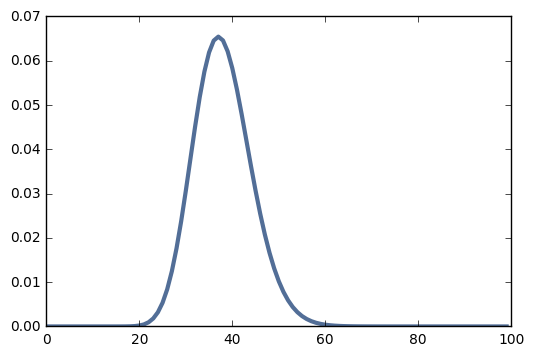

In [153]:
# First, we want to find the distribution of lambdas for the Poisson Distribution
insect = InsectPoisson(range(100)) # We can only have at most 100 triggered traps in one day from the problem definition
insect.Update(37)
thinkplot.Pdf(insect) # As expected, it centers around 37.

Mean: 73.7137236533    Mode: 74     Standard Deviation: 12.7800530302


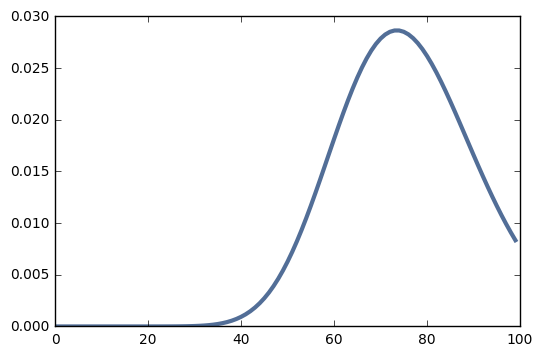

In [154]:
# From each hypothetical Poisson distribution, we can make a prediction for the number of insects in the following two days
# However, not all distributions are equally relavent; in fact their relevancy is given by the distribution found above.

prediction = Pmf(range(100)) # Once again, we will at most see 100 triggered traps

for trapNum, prob in prediction.Items():
    like = 0
    
    for lam, weight in insect.Items():
        like += weight * EvalPoissonPmf(trapNum, 2*lam) # Average is 2*lam because the ecologist checks after two days
        
    prediction[trapNum] = like
    
prediction.Normalize()
thinkplot.Pdf(prediction)
print('Mean:', prediction.Mean(), '   Mode:', prediction.Mode(), '    Standard Deviation:', prediction.Std())

From my highschool education, my first reflex was to state that lam = 37, and extrapolate that one should expect 74 triggered traps the next day.  

But thanks to Bayes, we can actually pull a probability distribution out of this! One odd result is that the mean of the distribution is different than the mode. Since there are only 100 traps, the distribution is significantly cut off, so the mean is closer to 73 than we might had originally expected. The standard deviation is surprisingly large as well, but with the little data we originally had this is to be expected.

## The Manufacturer Failure Rate Problem
#### By Matthew Beaudouin-Lafon
You've created a product and are trying to determine its failure rate. With the following data taken over three months, provide a probability distribution of a new product's lifetime.

Death status (-1 if still alive after 3 months of heavy use, otherwise lifetime in months):  
    -1  
    2.1  
    2.3  
    2.6  
    -1  
    2.7  

In [155]:
class Manufacturer(Suite, Joint):
    """
    Bayesian model for the manufacturer failure problem. Inherits from both 
    """
    def Likelihood(self, data, hypo):
        """
        Parameters:
            - data: death status (-1 if still alive after 3 months of heavy use, otherwise lifetime in months)
            - hypo: (k, lambda)
        """
        checkTime = 3 # months
        k, lmbd = hypo
        
        if data == -1: # If the product is still alive, then evaluate the probability that it's been alive all this time.
            prob = 1 - EvalWeibullCdf(checkTime, k, lmbd)
        else:          # If it died, evaluate the probability that it has died.
            prob = EvalWeibullPdf(data, k, lmbd)
            
        return prob

In [156]:
# Setting up the model
Ks = np.linspace(0.3, 6, 101)
Lambdas = np.linspace(0, 20, 101)
Ks = np.delete(Ks, 0)
Lambdas = np.delete(Lambdas, 0)
manu = Manufacturer(product(Ks, Lambdas))

In [157]:
# Perform updates
death = [-1, 2.1, 2.3, 2.6, -1, 2.7]
manu.UpdateSet(death)

0.0003191922171231189

3.0845022756645628

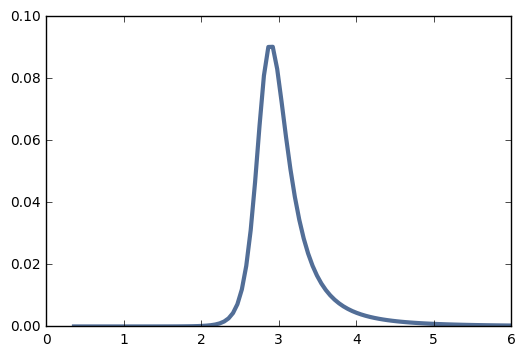

In [158]:
# Plot k probability distribution
thinkplot.Pdf(manu.Marginal(0))
manu.Marginal(0).Mean()

6.1576159188576884

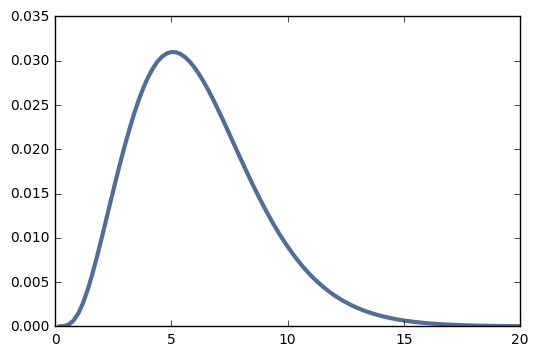

In [159]:
# Plot lambda probability distribution
thinkplot.Pdf(manu.Marginal(1))
manu.Marginal(1).Mean()

2.8097521009981947

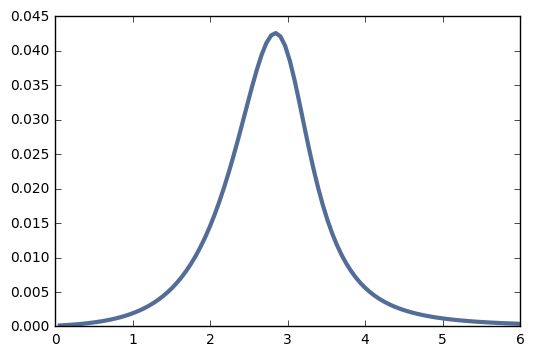

In [160]:
# Just like before, we can use these probability distributions to make a proability distribution of the item's lifetime
timeInterval = np.linspace(0, 6, 100)
timeInterval = np.delete(timeInterval, 0)
lifetime = Pmf(timeInterval) # Assume that the item's lifetime is between 0 and 6 months

for x, prob in lifetime.Items():
    like = 0
    for (k, lam), weight in manu.Items():
        like += manu[(k, lam)] * EvalWeibullPdf(x, k, lam) # Weigh the likelihood that the item lives for x amount of time with the manu distribution
    lifetime[x] = like

lifetime.Normalize()
thinkplot.Pdf(lifetime)
lifetime.Mean()

3.6363636363636367

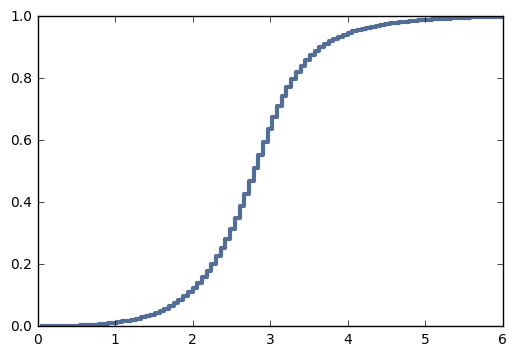

In [161]:
survival = Cdf(lifetime)
thinkplot.Pdf(survival)
survival.Value(0.9)

So I decided to model the survival using a Weibull distribution (or rather that's what I planned on using when creating the problem). As such, the first task was to generate a probability distribution for each parameter of the Weibull distribution, k and lambda. We could then produce a mixture that provided a Pmf for the lifetime of the item.  

Our results indicate that the product will most likely fail after 2.8 months. This aligns nicely with the intuition the data might provide. We can also look at the cumulative distribution to get a sense of when a certain proportion of future manufactored product might fail. For instance, according to our data 90% of them will fail after 3.6 month.

## Height Problem
#### By Matthew Beaudouin-Lafon
With the following data, if a man measures 1.676m in France, what is the probability distribution of his year of birth? Assume the standard deviation to be 5.

Data from https://ourworldindata.org/human-height/

In [162]:
frenchHeights = { 1810: 163.9,
                     1820: 163.9,
                     1830: 164.0,
                     1840: 164.3,
                     1850: 165.2,
                     1860: 165.5,
                     1870: 165.9,
                     1880: 166.1,
                     1890: 166.1,
                     1900: 166.8,
                     1910: 167.8,
                     1920: 168.5,
                     1930: 169.9,
                     1940: 171.7,
                     1950: 173.2,
                     1960: 174.9,
                     1970: 175.1,
                     1980: 176.5 }

In [163]:
class Height(Suite):
    def Likelihood(self, data, hypo):
        year = hypo
        mu = data
        sigma = 5
        return EvalNormalPdf(frenchHeights[year], mu, sigma)

1885.6031639094936

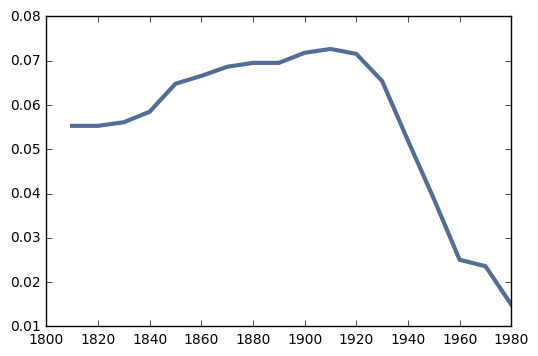

In [164]:
height = Height(list(data.keys()))
height.Update(167.6)
thinkplot.Pdf(height)
height.Mean()

This is a standard discrete Bayesian classification problem. Our likelihood function is nothing more than an evaluation of a normal distribution with mu being the average height, and 5 being the standard deviation (as given by the problem).

The resulting probability distribution doesn't follow any particular distribution, since it is a combination of normal distributions. It's the simple case for a mixture. 
We get that the person was most likely born in 1885.6, or July 6th 1885 (though granted that is a bit way too specific).

Note: The original problem I wanted to tackle involved determining the birth date and location in the world of an individual of a given height. However I ran into difficulties important the dataset, and needed to finish this report by 9 (we ended up working on the final project for a couple more hours). So instead of scrapping the problem, I decided to solve this really simplified version. It's a bit underwhelming, but at least it's something. I plan on finishing it later out of curiosity.